In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
import missingno as msno
from sklearn.utils import shuffle 
from category_encoders import TargetEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
sns.set(rc = {'figure.figsize': (20, 20)})
%matplotlib inline 

In [2]:
df = pd.read_json("cars_info.json")
df = df.dropna()
df.head(2)

,Prix,year,origin,firstCirculationDate,firstHand,mileage,energy,gearbox,externalColor,doors,ratedHorsePower,powerDIN,critAir,co2,owners
1,43570.0,2022.0,Importé,07/01/2023,Non,20 478 km,Diesel,Automatique,gris metal,4.0,10 CV,(DIN) 190 ch,2,132 g/km,2.0
2,26860.0,2019.0,France,30/09/2019,Non,97 988 km,Diesel,Manuelle,blanc,4.0,5 CV,(DIN) 125 ch,2,159 g/km,2.0


In [3]:
# Prétraitement
df['Prix'] = df['Prix'].astype(int)
df['year'] = df['year'].astype(int)
df['origin'] = df['origin'].replace({'Importé': 1, 'France': 0})
df['firstHand'] = df['firstHand'].replace({'Oui': 1, 'Non': 0})
df['mileage'] = df['mileage'].str.extract('(\d+)').astype(int) 
df['gearbox'] = df['gearbox'].replace({'Automatique': 1, 'Manuelle': 0})
df['ratedHorsePower'] = df['ratedHorsePower'].str.extract('(\d+)').astype(int)
df['powerDIN'] = df['powerDIN'].str.extract('(\d+)').astype(int)
df['doors'] = df['doors'].astype(int)
df['co2'] = df['co2'].str.extract('(\d+)').astype(int) 
df['critAir'] = df['critAir'].str.extract('(\d+)').astype(int) 
df['energy'] = df['energy'].replace({'Diesel' : 0,'Essence' : 1,'Hybride essence électrique' : 2,'Electrique' : 3,'Bicarburation essence bioéthanol' : 4,'Hybride diesel électrique' : 5})
df = df.drop(["firstCirculationDate", "externalColor"], axis=1)

In [1]:
df["energy"].unique()

NameError: name 'df' is not defined

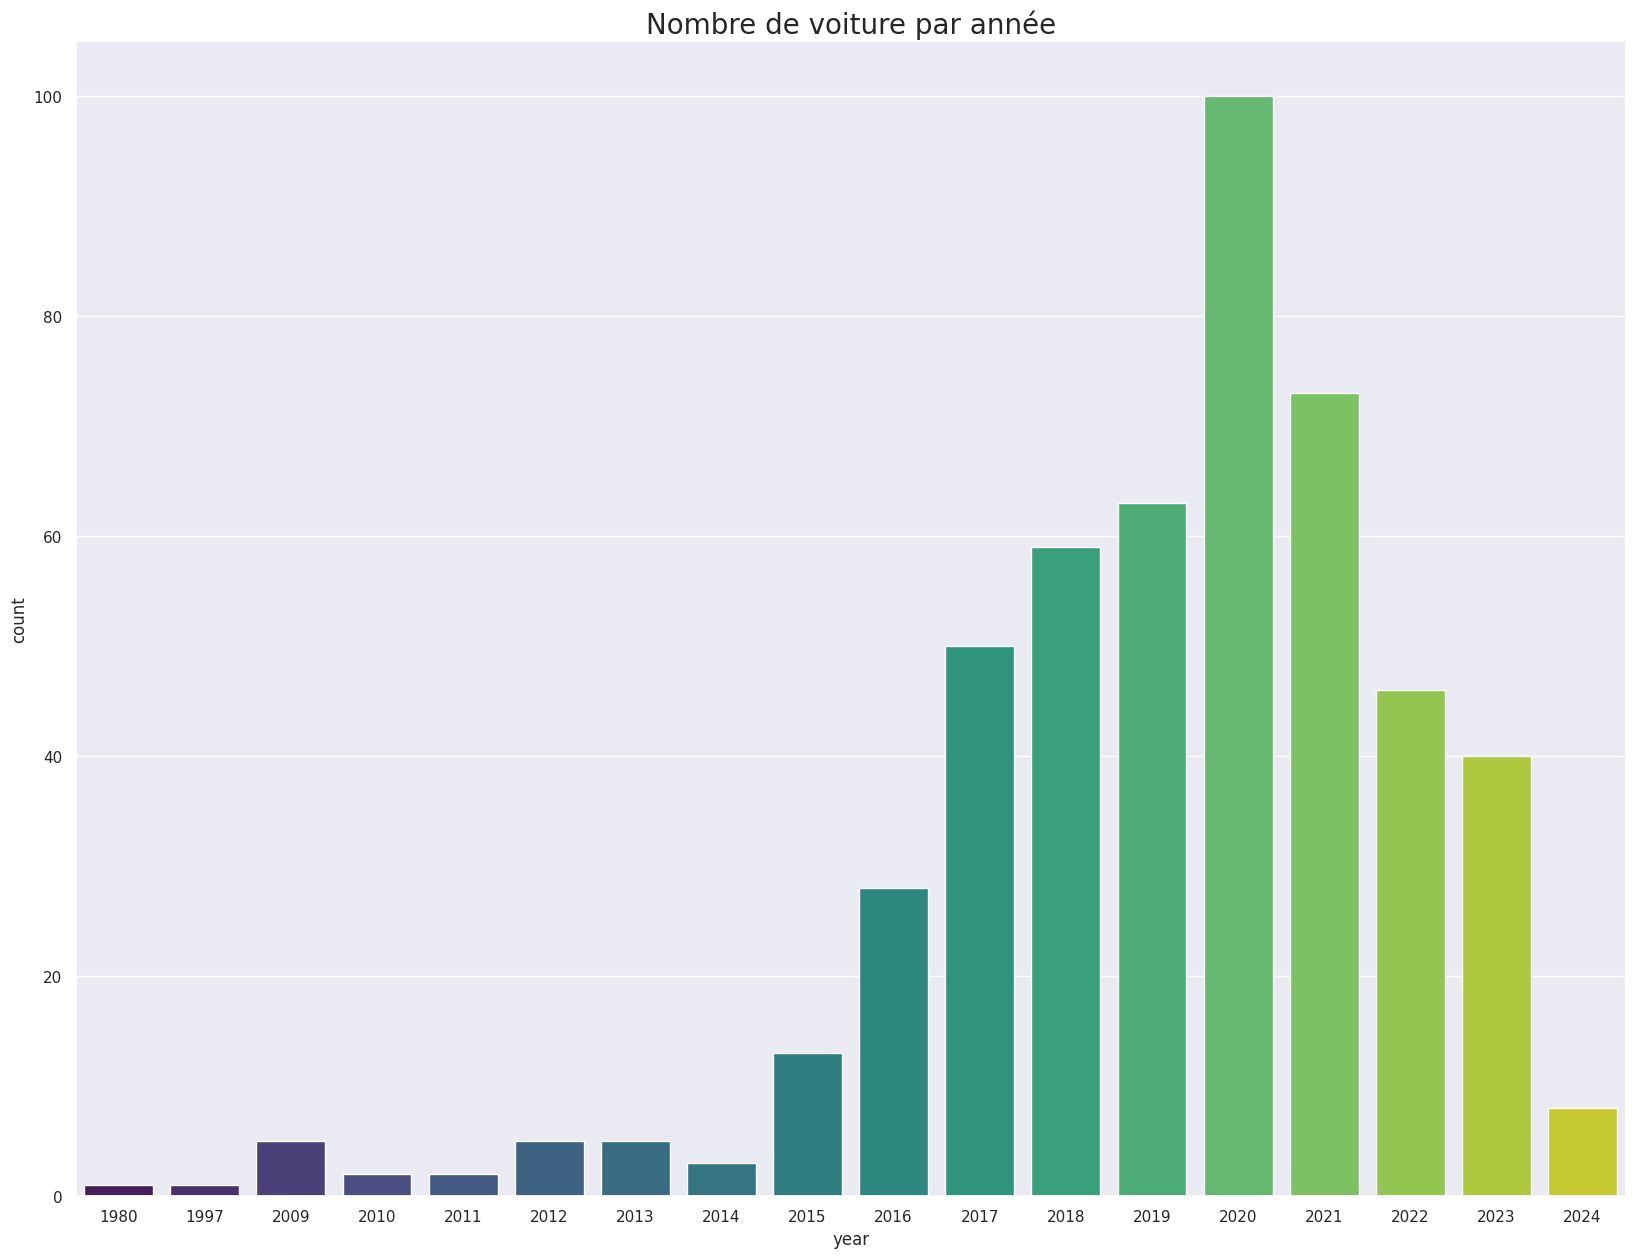

In [5]:
plt.figure(figsize = (20, 15))
sns.countplot(x=df.year, palette = 'viridis')
plt.title("Nombre de voiture par année", fontsize = 20)
plt.show()

<Axes: >

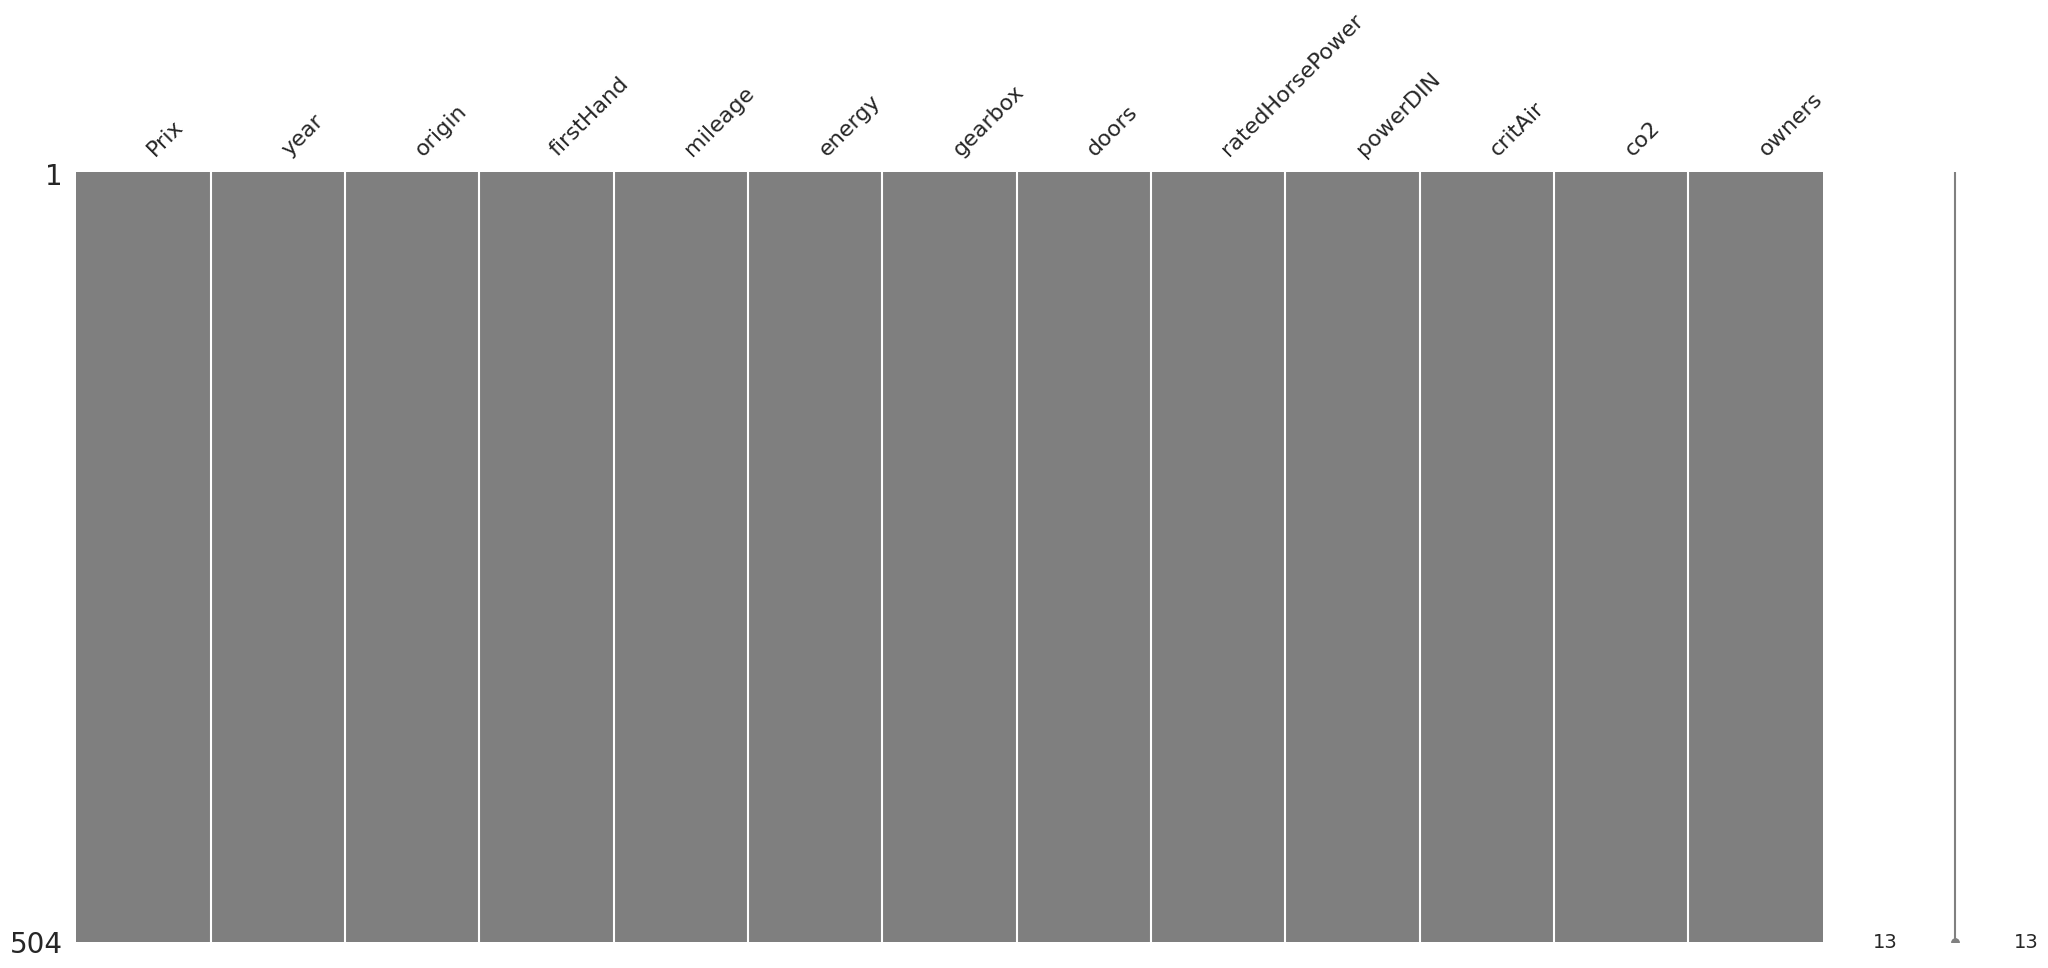

In [6]:
msno.matrix(df, color = (0.5, 0.5, 0.5))

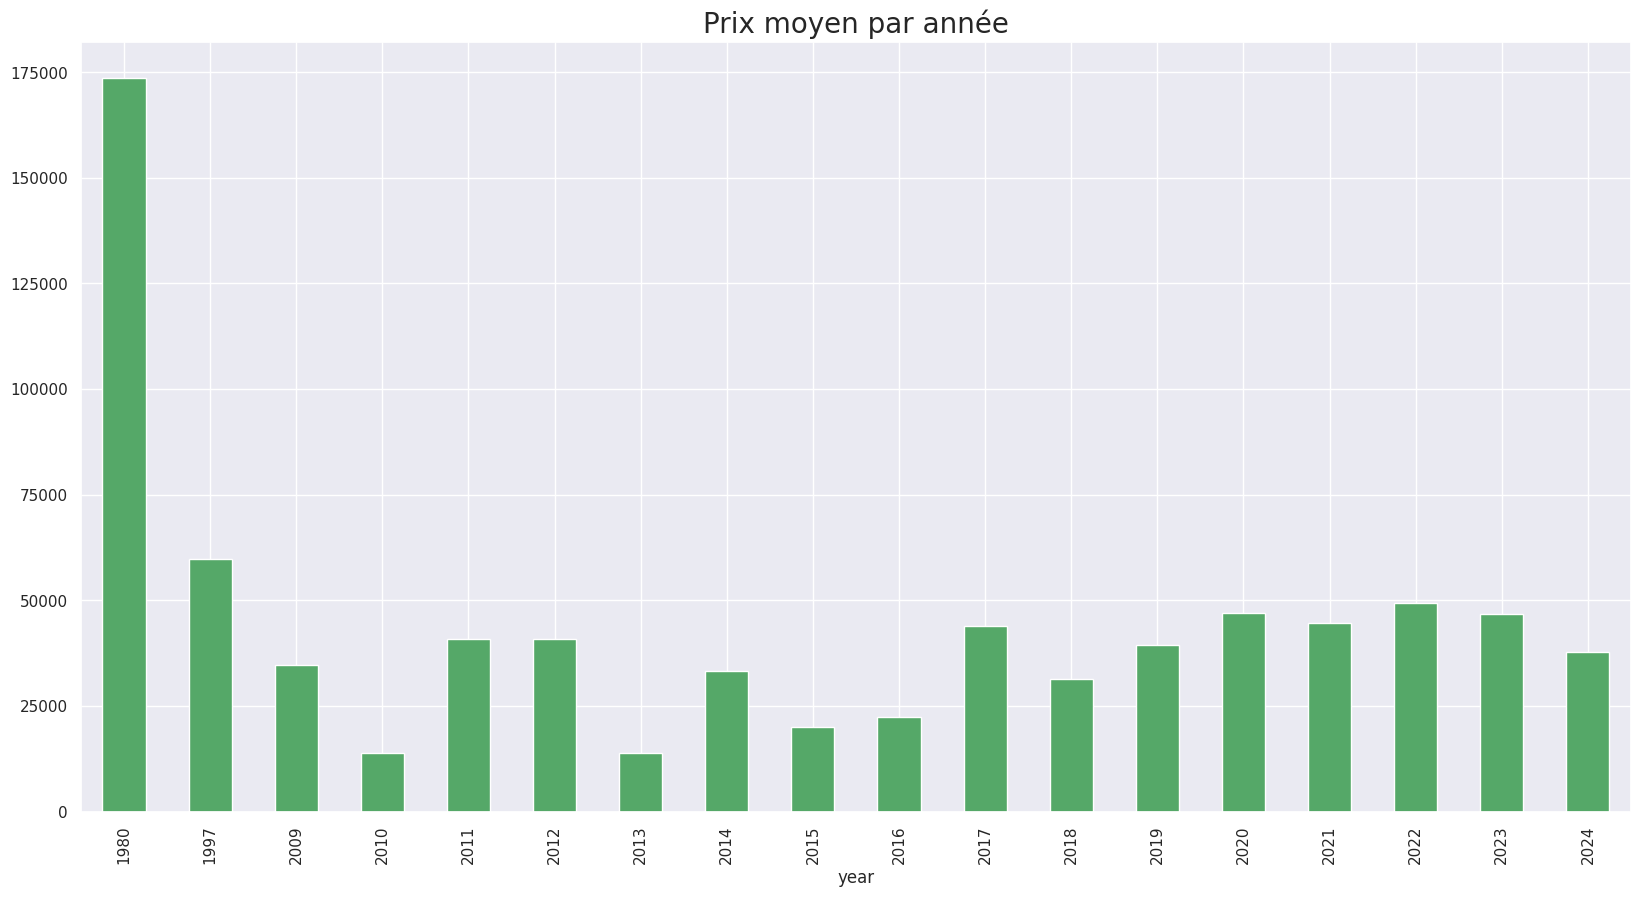

In [7]:
plt.figure(figsize = (20, 10))
df.groupby('year')['Prix'].mean().plot(kind = 'bar', color = 'g')
plt.title("Prix moyen par année", fontsize = 20)
plt.show()

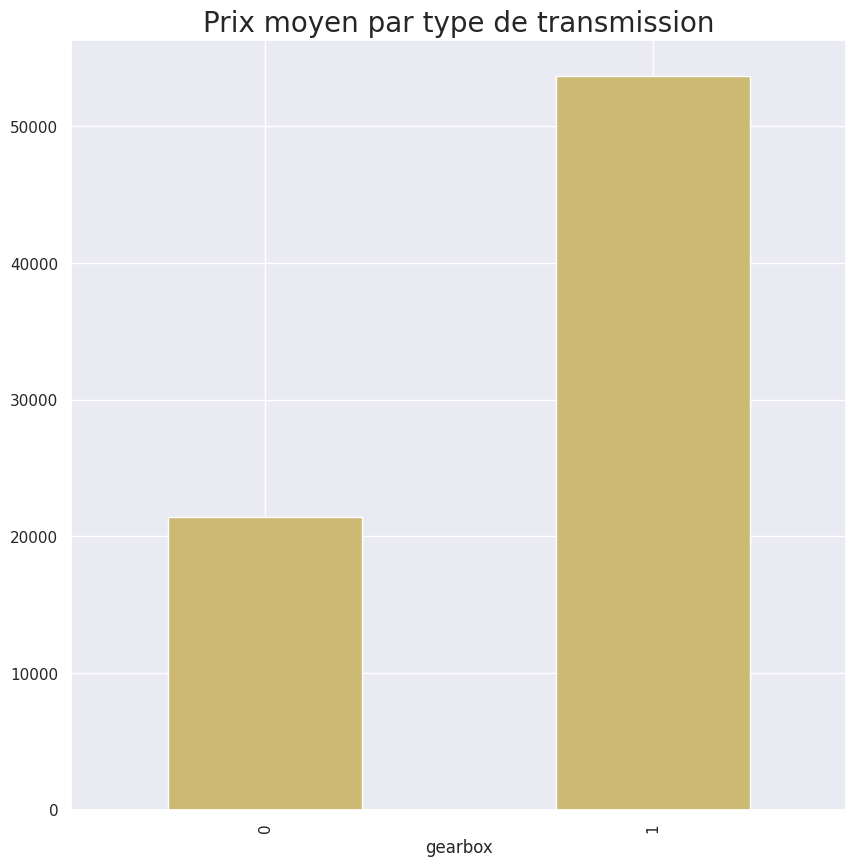

In [8]:
plt.figure(figsize = (10, 10))
df.groupby('gearbox')['Prix'].mean().plot(kind = 'bar', color = 'y')
plt.title("Prix moyen par type de transmission", fontsize = 20)
plt.show()

<Axes: >

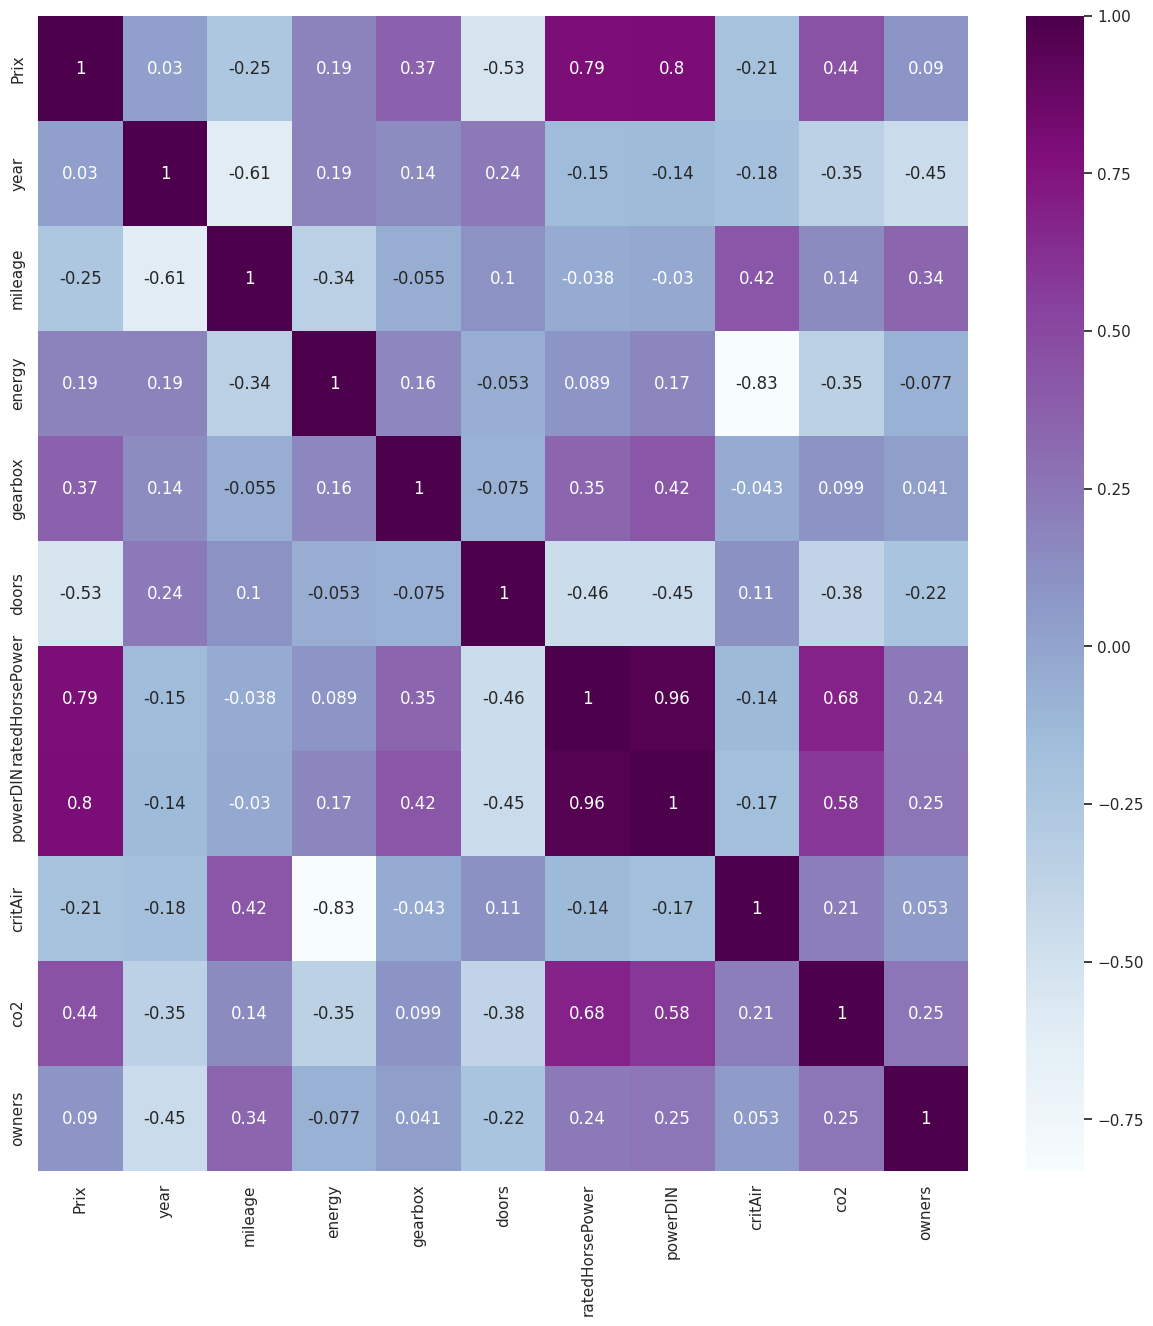

In [9]:
#"Prix", "year", "origin", "firstHand", "mileage", "energy", "gearbox", "doors", "ratedHorsePower", "powerDIN", "critAir", "co2", "owners"
plt.figure(figsize = (15, 15))
numeric_columns = ["Prix", "year", "mileage", "energy", "gearbox", "doors", "ratedHorsePower", "powerDIN", "critAir", "co2", "owners"]
heatmap_data = df[numeric_columns].corr()

sns.heatmap(heatmap_data, cmap = 'BuPu', annot = True)

In [10]:
X = df.drop(['Prix'], axis = 1)
y = df['Prix']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)


In [11]:
(X_train.shape), (X_test.shape)

((403, 12), (101, 12))

In [12]:
(y_train.shape), (y_test.shape)

((403,), (101,))

In [13]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_new = scaler.transform(X_train)
X_test_new = scaler.transform(X_test)

In [14]:
X_train_new.shape

(403, 12)

In [15]:
# Regression linéaire

model = LinearRegression()
model.fit(X_train_new, y_train)

LinearRegression()

In [16]:

y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])

In [17]:
y_predict.head()


,Prédiction
0,37740.744381
1,6199.782796
2,45574.414171
3,14637.938235
4,60075.691120


In [18]:

y_test.to_frame().head()

,Prix
1113,27480
623,14540
217,32740
101,24550
948,48380


In [19]:
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)
results.head()

,Prédiction,Prix
0,37740.744381,27480
1,6199.782796,14540
2,45574.414171,32740
3,14637.938235,24550
4,60075.691120,48380


In [20]:
# Stockage des erreurs des différents algo de prédictions
error_mean_square = []
error_mean_absolute = []
error_mean_square.append(int(mean_squared_error(y_predict, y_test)))
error_mean_absolute.append(int(mean_absolute_error(y_predict, y_test)))

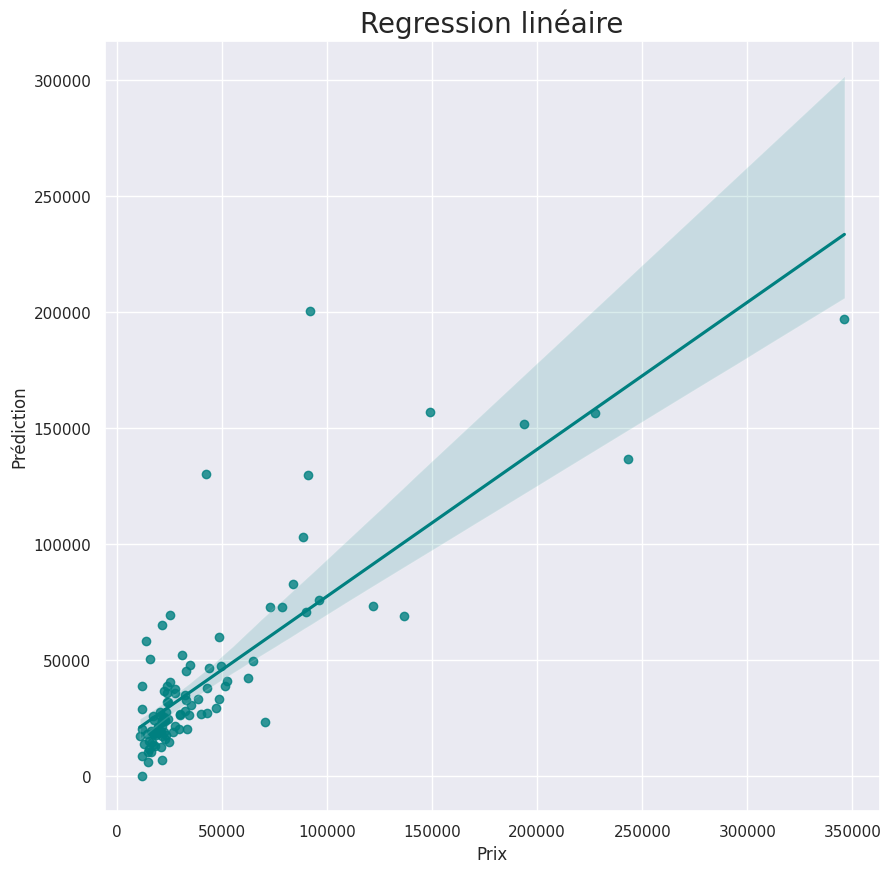

In [21]:
plt.figure(figsize = (10, 10))
sns.regplot(data = results, y = 'Prédiction', x = 'Prix', color = 'teal', marker = 'o')
plt.title("Regression linéaire", fontsize = 20)
plt.show()

In [22]:
# Regression voisine
model = KNeighborsRegressor(n_neighbors = 2)
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

error_mean_square.append(int(mean_squared_error(y_predict, y_test)))
error_mean_absolute.append(int(mean_absolute_error(y_predict, y_test)))

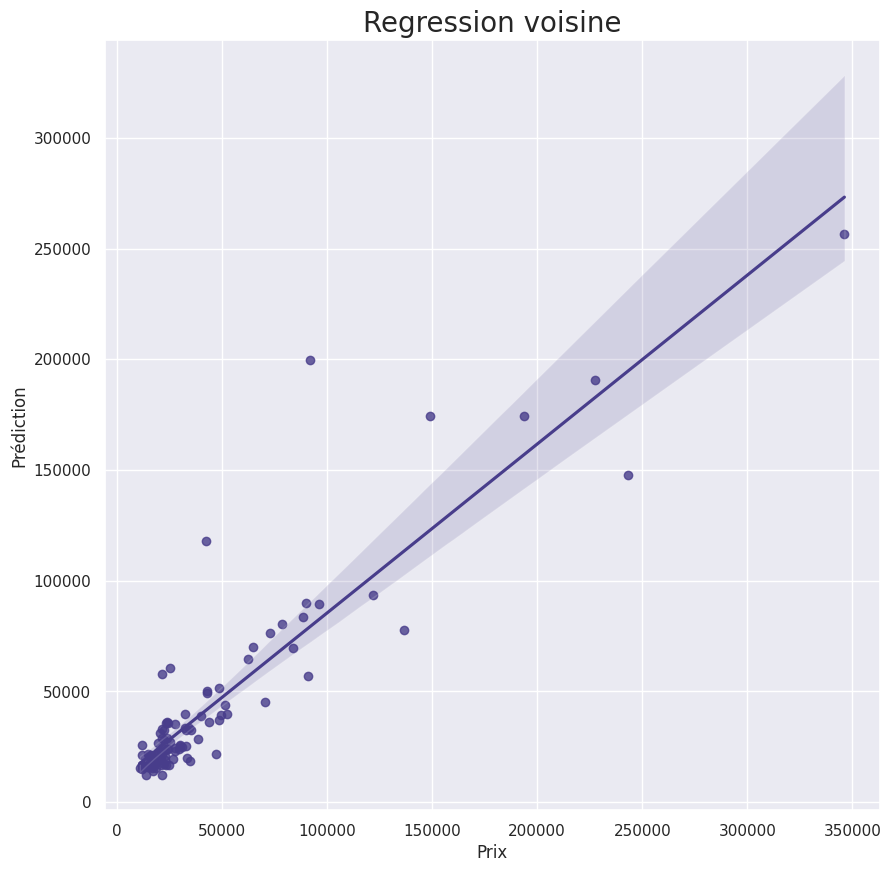

In [23]:
plt.figure(figsize = (10, 10))
sns.regplot(data = results, y = 'Prédiction', x = 'Prix', color = 'darkslateblue', marker = 'o')
plt.title("Regression voisine", fontsize = 20)
plt.show()

In [24]:
# Décision tree
model = DecisionTreeRegressor(splitter = 'random')
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

error_mean_square.append(int(mean_squared_error(y_predict, y_test)))
error_mean_absolute.append(int(mean_absolute_error(y_predict, y_test)))

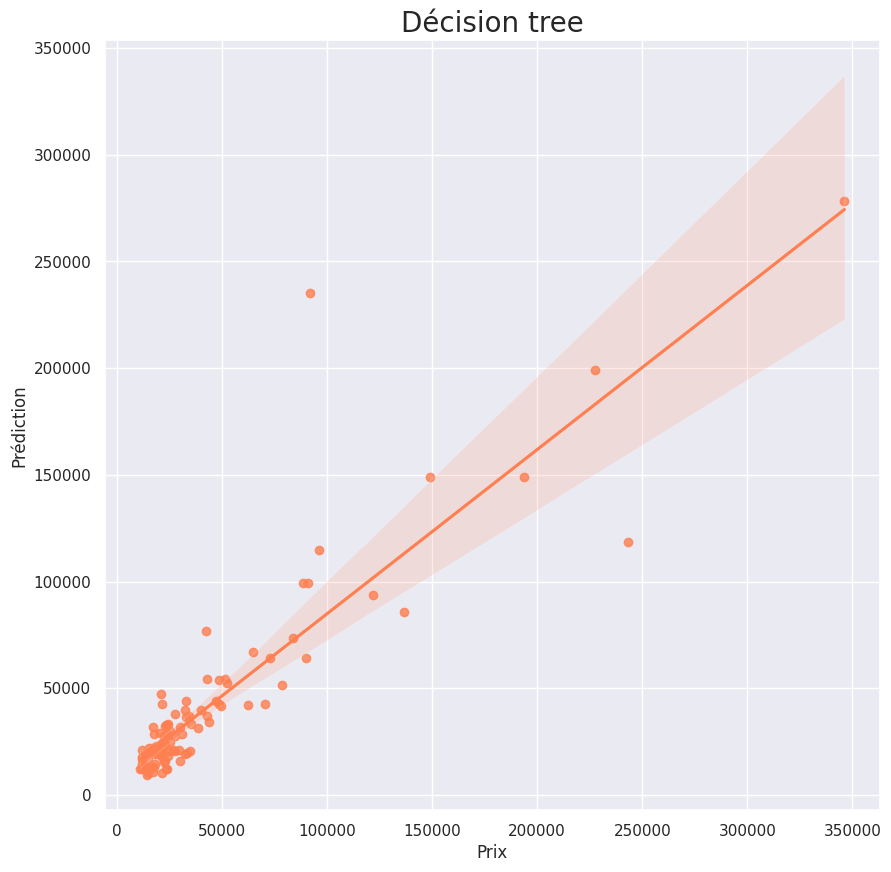

In [25]:
plt.figure(figsize = (10, 10))
sns.regplot(data = results, y = 'Prédiction', x = 'Prix', color = 'coral', marker = 'o')
plt.title("Décision tree", fontsize = 20)
plt.show()

In [33]:
model = MLPRegressor(hidden_layer_sizes = 50, alpha = 0.001, solver = 'lbfgs', learning_rate = 'adaptive')
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

error_mean_square.append(int(mean_squared_error(y_predict, y_test)))
error_mean_absolute.append(int(mean_absolute_error(y_predict, y_test)))

In [37]:
#print (model.coefs_)

result = model.score(X_test, y_test)
print(result)

-116811634.52722453


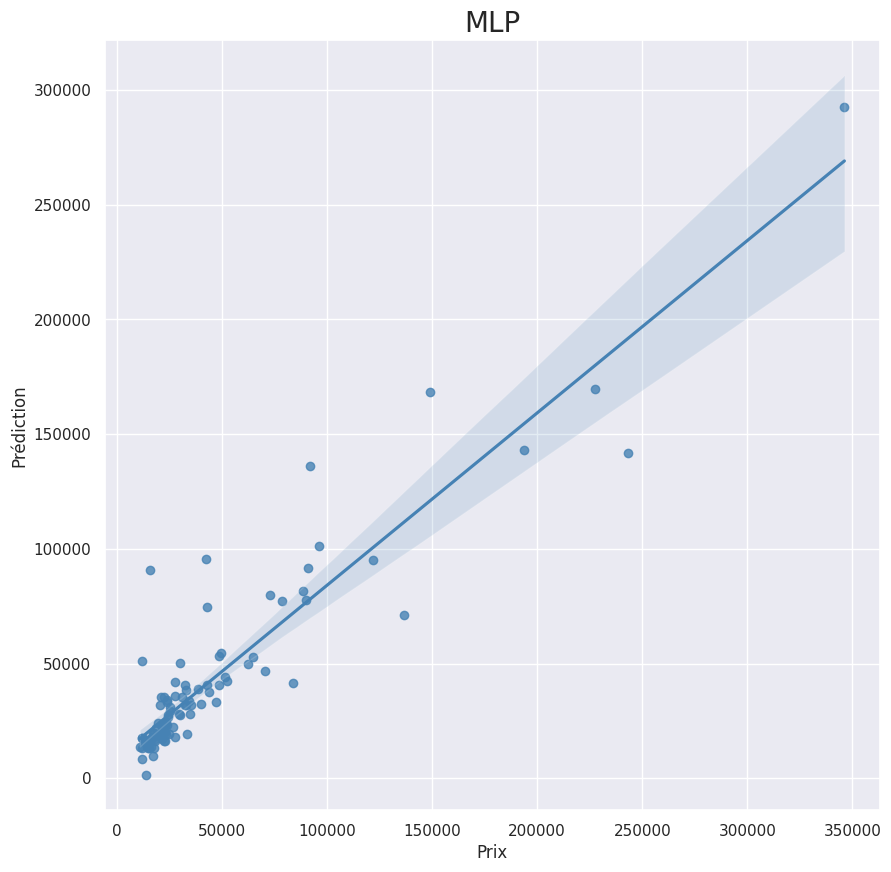

In [27]:
plt.figure(figsize = (10, 10))
sns.regplot(data = results, y = 'Prédiction', x = 'Prix', color = 'steelblue', marker = 'o')
plt.title("MLP", fontsize = 20)
plt.show()

In [28]:
error_mean_absolute

[15580, 11290, 11492, 10996]

In [29]:
error_mean_square

[845678476, 491834846, 554730378, 429843742]

In [30]:
# Comparaison des erreurs
data = {'Models': ['Regression linéaire', 'Regression voisine', 'Décision tree', 'MLP'], 'Mean Absolute Error': error_mean_absolute, 'Mean Squared Error': error_mean_square}
model_dataframe = pd.DataFrame(data)
model_dataframe

,Models,Mean Absolute Error,Mean Squared Error
0,Regression linéaire,15580,845678476
1,Regression voisine,11290,491834846
2,Décision tree,11492,554730378
3,MLP,10996,429843742


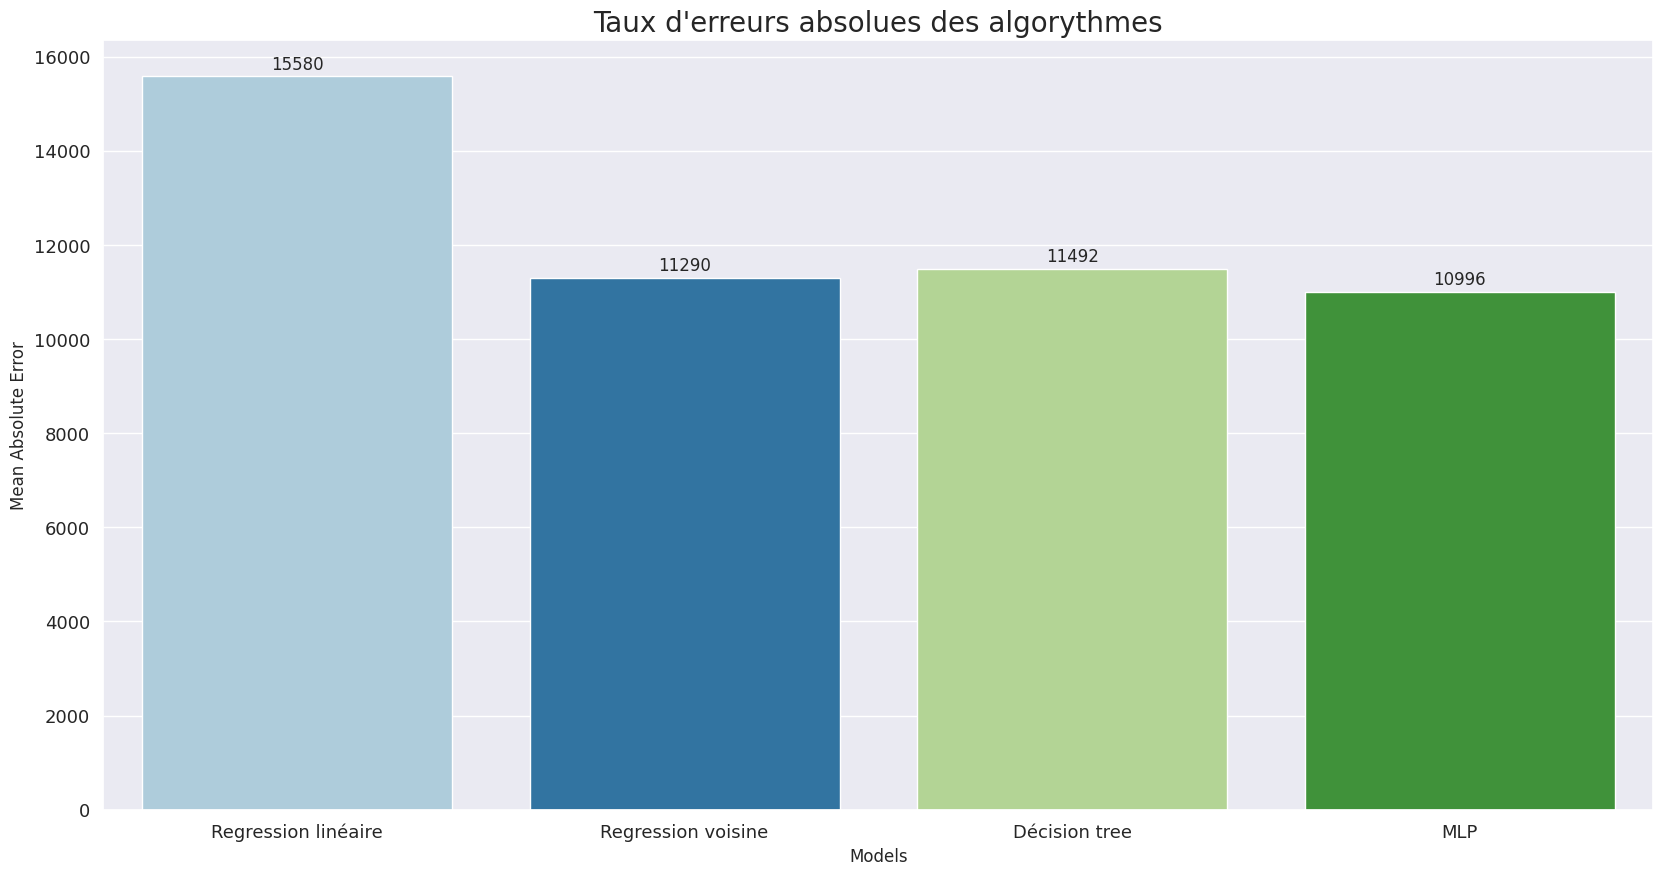

In [31]:
plt.figure(figsize = (20, 10))
splot = sns.barplot(data = model_dataframe, x = 'Models', y = 'Mean Absolute Error', palette = 'Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Taux d'erreurs absolues des algorythmes", fontsize = 20)
plt.show()

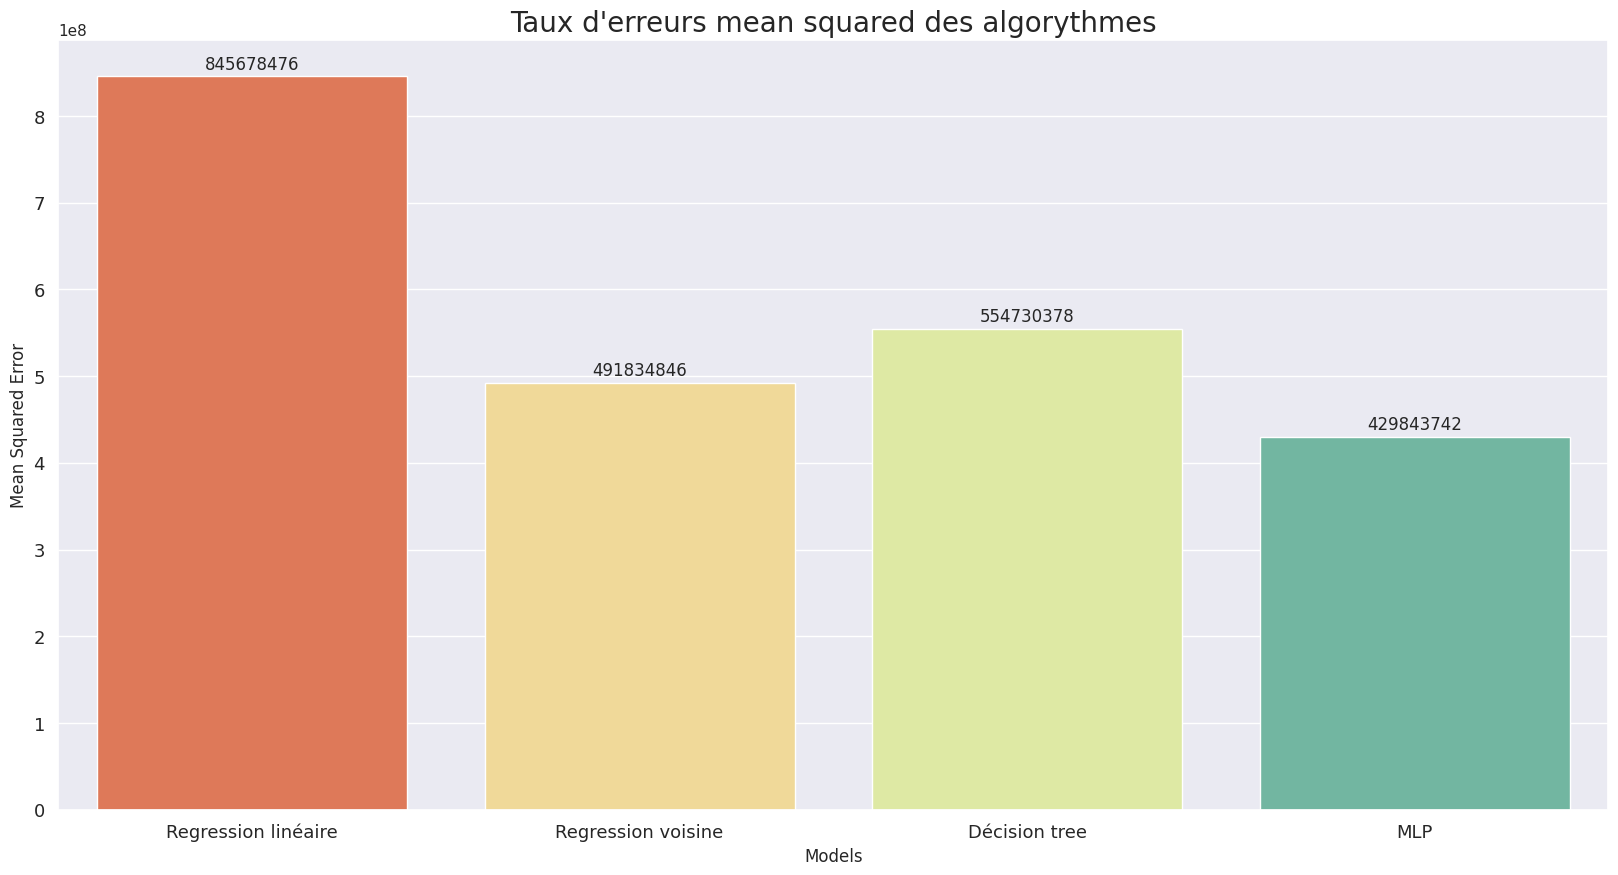

In [32]:
plt.figure(figsize = (20, 10))
splot = sns.barplot(data = model_dataframe, x = 'Models', y = 'Mean Squared Error', palette = 'Spectral')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Taux d'erreurs mean squared des algorythmes", fontsize = 20)
plt.show()

In [39]:
# Train MLP Regressor
model = MLPRegressor(hidden_layer_sizes = 50, alpha = 0.001, solver = 'lbfgs', learning_rate = 'adaptive')
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

In [40]:
# Export model
import pickle
filename = 'regressor_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# Load Model
loaded_model = pickle.load(open('regressor_model.sav', 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

In [41]:
df.head()

,Prix,year,origin,firstHand,mileage,energy,gearbox,doors,ratedHorsePower,powerDIN,critAir,co2,owners
1,43570,2022,1,0,20,0,1,4,10,190,2,132,2.0
2,26860,2019,0,0,97,0,0,4,5,125,2,159,2.0
4,42880,2023,0,0,22,0,1,5,7,136,2,136,1.0
9,23830,2021,0,0,15,1,1,5,7,131,1,141,1.0
17,54270,2024,0,0,18,1,1,5,8,150,1,160,1.0


In [54]:
# Fir data to the mongodb return
test_car = df.head(1).drop("Prix", axis=1).to_dict("records")
X = pd.DataFrame(test_car)

In [55]:
# test prediction
scaler = MinMaxScaler()
scaler.fit(X)
X_test = scaler.transform(X)
y_predict = model.predict(X_test)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])

In [56]:
y_predict

,Prédiction
0,280829.425824


In [58]:
import json
json_object = json.dumps(test_car, indent=4)
with open("sample.json", "w") as outfile:
    outfile.write(json_object)

In [59]:
test_car

[{'year': 2022,
  'origin': 1,
  'firstHand': 0,
  'mileage': 20,
  'energy': 0,
  'gearbox': 1,
  'doors': 4,
  'ratedHorsePower': 10,
  'powerDIN': 190,
  'critAir': 2,
  'co2': 132,
  'owners': 2.0}]